## Imports

In [2]:
from __future__ import division
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import cv2
from random import shuffle
import random
import glob
from skimage.transform import resize
import os
from model import *
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from collections import defaultdict
import itertools
from tqdm import tqdm
import time
import shutil
from inception_resnet_v2_10_3_3 import *

Using TensorFlow backend.


## Hyperparameters

In [3]:
dataset_path = 'train'
model_name = 'InceptionResNet-v2-10-3-3'
num_classes = 11
input_shape=(256,256,3)
batch_size = 30
nb_epoch = 200

In [4]:
def batch_generator(data_X, data_y, batch_size):
    indexes = np.array(range(len(data_y)))
    n = len(indexes)
    while True:
        batch_start = 0
        batch_end = batch_size
        np.random.shuffle(indexes)
        while batch_start < n:
            index = []
            batch_y = []
            y = []
            index = indexes[batch_start:batch_end]
            batch_x = np.array([data_X[i] for i in index])
            batch_y = np.array([data_y[i] for i in index])
            yield batch_x, batch_y
            batch_start += batch_size   
            batch_end += batch_size
            if (batch_end>len(data_y)):
                batch_end = len(data_y)

In [5]:
def read_dataset(dataset_path, im_type):
    import glob
    paths_X = []   
    labels = [] 
    i = 0
    folders = sorted(os.listdir(dataset_path))
    for folder in folders:
        temp = sorted (glob.glob(os.path.join(dataset_path,folder+'/*'+im_type)))
        for k in range(len(temp)):
            labels.append (i)
        paths_X += temp
        i += 1
        
    if(len(paths_X)==0):
        print ('Dataset could not found. Please provide correct path.')
    return paths_X, labels

In [6]:
paths, labels = read_dataset(dataset_path, '[(.png)(.jpg)]')
X = np.array([cv2.imread(image_name) for image_name in paths]) 
y = to_categorical(labels, num_classes)

In [7]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Display dataset stats

0 blackfarms 618
1 densetrees 600
2 farms 599
3 grass 599
4 ground 594
5 houses 603
6 kiln 1084
7 orchard 593
8 parking 582
9 roads 600
10 unevenland 742


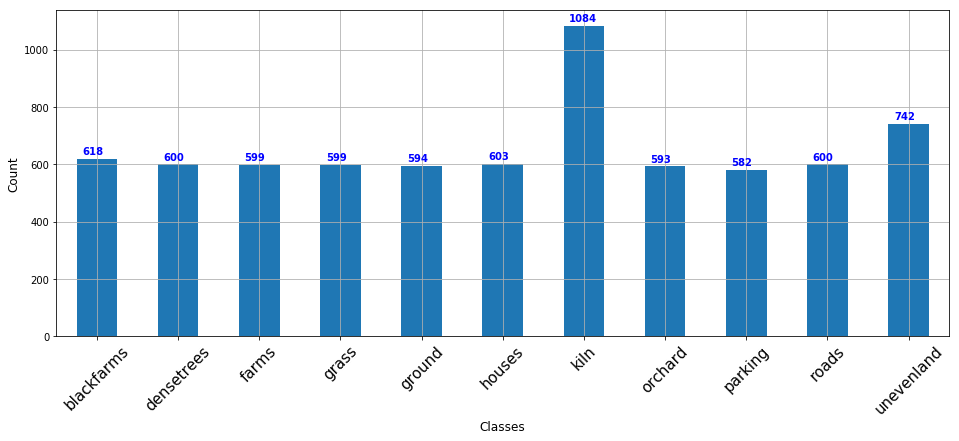

In [8]:
folders = os.listdir(dataset_path)
names, counts = [], []
for i, folder in enumerate(folders):
    dir_path = os.path.join(dataset_path, folder)
    images = os.listdir(dir_path)
    names.append(folder)
    counts.append(len(images))
    print(i, folder, len(images))
df = pd.DataFrame(data={'Name': names, 'Count': counts})
ax = df.plot(kind='bar', xticks=counts, grid=True, legend=False, figsize=(16,6))
ax.set_xlabel('Classes', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.xticks(np.arange(len(names)), names, rotation=45, fontsize=15)
for i, v in enumerate(counts):
    ax.text(i-.18, v+15, str(v), color='blue', fontweight='bold')
plt.show()

In [9]:
model =MyInceptionResNetV2(include_top=True, weights=None, input_tensor=None, input_shape=input_shape, pooling=None, classes=num_classes)
model.summary()
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
#plot_model(model, to_file='model.png')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 127, 127, 32) 96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 127, 127, 32) 0           Conv2d_1a_3x3_BatchNorm[0][0]    
__________________________________________________________________________________________________
Conv2d_2a_

In [10]:
class_weights = {0: 1084/618,
                1: 1084/600,
                2: 1084/599,
                3: 1084/599,
                4: 1084/594,
                5: 1084/603,
                6: 1,
                7: 1084/593,
                8: 1084/582,
                9: 1084/600,
               10: 1084/742
               }

In [16]:
checkpoint = ModelCheckpoint(model_name+'.h5', monitor='val_loss', verbose=2, save_best_only=True, mode='auto')
tensorboard = TensorBoard(log_dir='TENSORBOARD/', batch_size=batch_size, write_graph=True, write_images=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=3, min_lr=0.00001)
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=2, mode='auto')
cvslogger = keras.callbacks.CSVLogger(model_name+'.csv', separator=',', append=True)
callbacks = [checkpoint, reduce_lr, earlystop, cvslogger, tensorboard]

kf = KFold(n_splits=10)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    train_gen = batch_generator(X_train, y_train, batch_size)
    test_gen = batch_generator(X_test, y_test, batch_size)
    history = model.fit_generator(train_gen, int(len(y_train)//batch_size), epochs=nb_epoch, verbose=1, 
                    max_queue_size=2, validation_data=test_gen, 
                    validation_steps=int(len(y_test)//batch_size), shuffle=True,
                    workers=1, use_multiprocessing= False, 
                    initial_epoch=0, callbacks=callbacks, class_weight=class_weights)

Epoch 1/200
216/216 [==============================] - 67s 308ms/step - loss: 1.4161 - acc: 0.7164 - val_loss: 10.4205 - val_acc: 0.0097

Epoch 00001: val_loss improved from inf to 10.42047, saving model to InceptionResNet-v2-10-3-3-5-april-1084Kiln.h5
Epoch 2/200
216/216 [==============================] - 55s 254ms/step - loss: 0.7979 - acc: 0.8380 - val_loss: 11.5128 - val_acc: 0.0462

Epoch 00002: val_loss did not improve from 10.42047
Epoch 3/200
216/216 [==============================] - 54s 250ms/step - loss: 0.5074 - acc: 0.8988 - val_loss: 9.8450 - val_acc: 0.1445

Epoch 00003: val_loss improved from 10.42047 to 9.84498, saving model to InceptionResNet-v2-10-3-3-5-april-1084Kiln.h5
Epoch 4/200
216/216 [==============================] - 54s 251ms/step - loss: 0.3486 - acc: 0.9276 - val_loss: 12.7857 - val_acc: 0.1301

Epoch 00004: val_loss did not improve from 9.84498
Epoch 5/200
216/216 [==============================] - 54s 251ms/step - loss: 0.3372 - acc: 0.9332 - val_loss: 1


Epoch 00006: val_loss did not improve from 0.00147
Epoch 7/200
216/216 [==============================] - 54s 249ms/step - loss: 0.1568 - acc: 0.9710 - val_loss: 0.2663 - val_acc: 0.8858

Epoch 00007: val_loss did not improve from 0.00147
Epoch 8/200
216/216 [==============================] - 54s 249ms/step - loss: 0.1482 - acc: 0.9704 - val_loss: 0.2975 - val_acc: 0.8642

Epoch 00008: val_loss did not improve from 0.00147
Epoch 00008: early stopping
Epoch 1/200
216/216 [==============================] - 54s 250ms/step - loss: 0.2310 - acc: 0.9542 - val_loss: 0.0953 - val_acc: 0.9583

Epoch 00001: val_loss did not improve from 0.00147
Epoch 2/200
216/216 [==============================] - 55s 254ms/step - loss: 0.2337 - acc: 0.9524 - val_loss: 0.0903 - val_acc: 0.9609

Epoch 00002: val_loss did not improve from 0.00147
Epoch 3/200
216/216 [==============================] - 54s 250ms/step - loss: 0.2116 - acc: 0.9586 - val_loss: 0.0821 - val_acc: 0.9638

Epoch 00003: val_loss did not i

216/216 [==============================] - 54s 250ms/step - loss: 0.1932 - acc: 0.9651 - val_loss: 0.0165 - val_acc: 0.9928

Epoch 00012: val_loss did not improve from 0.00147
Epoch 13/200
216/216 [==============================] - 54s 250ms/step - loss: 0.1829 - acc: 0.9662 - val_loss: 0.0276 - val_acc: 0.9884

Epoch 00013: val_loss did not improve from 0.00147
Epoch 14/200
216/216 [==============================] - 54s 249ms/step - loss: 0.2058 - acc: 0.9615 - val_loss: 0.0173 - val_acc: 0.9928

Epoch 00014: val_loss did not improve from 0.00147
Epoch 00014: early stopping
Epoch 1/200
216/216 [==============================] - 54s 250ms/step - loss: 0.1949 - acc: 0.9603 - val_loss: 0.0211 - val_acc: 0.9944

Epoch 00001: val_loss did not improve from 0.00147
Epoch 2/200
216/216 [==============================] - 54s 250ms/step - loss: 0.1972 - acc: 0.9618 - val_loss: 0.0238 - val_acc: 0.9928

Epoch 00002: val_loss did not improve from 0.00147
Epoch 3/200
216/216 [=====================

# Sanity Check

In [17]:
model.evaluate_generator(test_gen, steps=len(X_test)//batch_size)

[0.012776826363982323, 0.992764106535187]

In [18]:
Tdataset_path = 'test'
Tpaths, Tlabels = read_landUse(Tdataset_path, '[(.png)(.jpg)]')
Timages = np.array([cv2.imread(image_name) for image_name in Tpaths]) 
X_test = Timages
y_test = to_categorical(Tlabels, num_classes)

In [19]:
y_pred = model.predict(X_test)

class_labels = {0: 'blackfarms', 1: 'densetrees', 2: 'farms', 3: 'grass', 4: 'ground',5: 'houses',6:'kiln',7:'orchard',8:'parking',9:'roads',10:'unevenland'}

In [20]:
preds=y_pred
print(preds.shape)

(1518, 11)


In [21]:
pres_classes = []
for p in preds.argmax(axis=1):
    pres_classes.append(class_labels[p])
#print(pres_classes)

In [22]:
truth_classes = []
for p in y_test.argmax(axis=1):
    truth_classes.append(class_labels[p])
#print(truth_classes)

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
def my_confusion_matrix(y_test, y_pred, classes):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=classes,title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,title='Normalized confusion matrix')

    plt.show()
    return cnf_matrix

Confusion matrix, without normalization
[[ 81   0   0   0  19   0   0   0   0   0   0]
 [  0  69  25   0   0   0   0   4   0   2   0]
 [  0   0  98   2   0   0   0   0   0   0   0]
 [  0   7   0  92   0   0   0   0   0   0   1]
 [  0   0   0   0  34   0   4   1   0   0  61]
 [  0   0   0   0   0  99   0   0   1   0   0]
 [ 13   0   0   2   1 137 354   6   0   0   5]
 [  0   0   0   0   0   0   0 100   0   0   0]
 [  0   0   0   0   0   1   0   0  92   7   0]
 [  7   0   0   0  13  17   5   0  13  45   0]
 [  0   0   0   0   0   0   2   0   0   0  98]]
Normalized confusion matrix
[[0.81 0.   0.   0.   0.19 0.   0.   0.   0.   0.   0.  ]
 [0.   0.69 0.25 0.   0.   0.   0.   0.04 0.   0.02 0.  ]
 [0.   0.   0.98 0.02 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.07 0.   0.92 0.   0.   0.   0.   0.   0.   0.01]
 [0.   0.   0.   0.   0.34 0.   0.04 0.01 0.   0.   0.61]
 [0.   0.   0.   0.   0.   0.99 0.   0.   0.01 0.   0.  ]
 [0.03 0.   0.   0.   0.   0.26 0.68 0.01 0.   0.   0.01]
 [0.   0

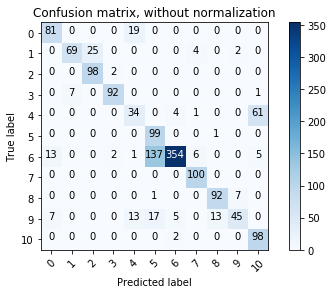

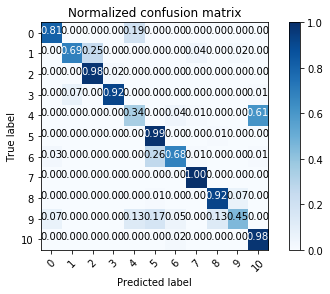

In [25]:
cm = my_confusion_matrix(truth_classes,pres_classes,class_labels)

In [26]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()
# Precision Calculation https://www.python-course.eu/confusion_matrix.php
# Precision Calculation https://www.python-course.eu/confusion_matrix.php
a = precision(6,cm)
b = recall(6,cm)
print('Precision', a)
print('Recall', b)
print('F1', (2*a*b)/(a+b))

Precision 0.9698630136986301
Recall 0.6833976833976834
F1 0.8018120045300113


In [8]:
####################################################
# test_images_dir = 'lhr/newtask'
test_images_dir = 'Bangladesh_zoom20/'

# results_dir = 'results_lahore_17_with_old_wets_attempt2'
results_dir = 'RESULTS/Bangladesh_zoom20-10-3-3/'
if not os.path.exists(results_dir):
    print('Creating new results directory "{}"'.format(results_dir))
    os.mkdir(results_dir)
im_dir = os.path.join(results_dir, 'images')
if not os.path.exists(im_dir):
    os.mkdir(im_dir)

#for file in os.listdir(test_images_dir):
#    curr_name, curr_ext = os.path.splitext(file)
 #   print(curr_name[:-1])
 #   break
#    new_name = curr_name[:-1]
#    os.rename(os.path.join(test_images_dir, file), os.path.join(test_images_dir, new_name+curr_ext))

########################################################
########### RENAMING DONE IN DOWNLOAD SCRIPT ###########
########################################################

Testing the model and creating result files

In [9]:
## print('Waiting'len(images)len(images)len(images), end='', flush=True)len(images)
# while True:
    
 #   if len(os.listdir(test_images_dir)) != 544244:
 #      time.sleep(10*60)
 #       print('.', end='', flush=True)
 #       continue


# if os.path.exists(os.path.join(results_dir, 'houses.txt')) or os.path.exists(os.path.join(results_dir, 'test.csv')):
#     raise OSError('Result files already present, this script will append to the existing data.')
    
# label_names = {0: 'parking', 1: 'parks', 2: 'ground', 3: 'houses', 4: 'roads', 5: 'mosque', 6: 'densetrees', 7: 'kiln', 8: 'oiltanks', 9: 'tennis', 10: 'ponds', 11: 'grass', 12: 'blackfarms', 13: 'farms', 14: 'orchard'}
# label_names = {0: 'parking', 1: 'parks', 2: 'ground', 3: 'houses', 4: 'roads', 5: 'mosque', 6: 'densetrees', 7: 'kiln', 8: 'oiltanks', 9: 'tennis', 10: 'ponds', 11: 'grass', 12: 'blackfarms', 13: 'farms'}
# label_names = {0: 'blackfarms', 1: 'densetrees', 2: 'farms', 3: 'grass', 4: 'ground', 5: 'houses', 6: 'kiln', 7: 'mosque', 8: 'oiltanks', 9: 'orchard', 10: 'parking', 11: 'parks', 12: 'ponds', 13: 'roads', 14: 'tennis'}
label_names = {0: 'blackfarms', 1: 'densetrees', 2: 'farms', 3: 'grass', 4: 'ground', 5: 'houses', 6: 'kiln', 7: 'orchard', 8: 'parking', 9: 'roads', 10:'unevenland'}
y_tiles, x_tiles = [], []
label_probs = defaultdict(list)
top_label_probs = defaultdict(list)

# # Resuming check
# try:
#     with open(os.path.join(results_dir, 'last_file_done.txt'), 'r') as f:
#         loop_index = int(f.read())
#     print('Resuming from file index "{}"'.format(loop_index))
# except FileNotFoundError:
#     loop_index = 0
#     print('Starting fresh from file index "0"')

filenames = os.listdir(test_images_dir)

# # Missing images check
# try:
#     with open(os.path.join(results_dir, 'missing_images.txt'), 'r') as f:
#         missing_images = [name.strip() for name in f.readlines()]
#     print('Continuing with {} missing images.'.format(len(missing_images)))
# except FileNotFoundError:
#     missing_images = []
#     print('Starting fresh with empty missing images list')
for img_name in tqdm(filenames):


#     extt=img_name.split('.')[1]
    orig_name, extt = os.path.splitext(img_name)
    if(extt == '.jpg'):
        img_orig = cv2.imread(os.path.join(test_images_dir, img_name), cv2.IMREAD_COLOR)
        # To catch corrupt images
        if type(img_orig) == type(None):
            print('Skipping an image "{}"'.format(img_name))
        #    missing_images.append(img_name)
            continue

        img = np.expand_dims(img_orig, axis=0)
        class_name = img_name.split('.')[0]

        pred = model.predict(img, verbose=0)
    #    preds.append((pred.argmax(), pred.max(), class_name))

#         src = os.path.join(test_images_dir, img_name)
#         dst = os.path.join(results_dir, 'images', orig_name+'_'+label_names[pred.argmax()]+extt)
#         shutil.copyfile(src, dst)
#         print(img_name, dst)

#         break
        x_tile, y_tile = os.path.splitext(img_name)[0].split('_')
        y_tiles.append(y_tile)
        x_tiles.append(x_tile)

        # Append to individual results files on each itteration
        for i, label in label_names.items():
            file_path = os.path.join(results_dir, label+'.txt')
            label_probs[label].append(pred[0, i])
            with open(file_path, 'a') as f:
                f.write('{} {} {}\n'.format(y_tile, x_tile, pred[0, i]))
#         # Append to full result file on every 1000 itterations
#         #if loop_index % 1000 == 0:
#         d = {'y_tile': y_tiles, 'x_tile': x_tiles}
#         d.update(label_probs)
#         final_df = pd.DataFrame(data=d)
#         final_df.to_csv(os.path.join(results_dir, 'test.csv'), index=False, header=True)
        # Resuming 
        #with open('last_file_done.txt', 'w') as f:
         #   f.write(str(loop_index))
        # Write names of corrupted files for later use
        #with open(os.path.join(results_dir, 'missing.txt'), 'w') as f:
           # for i in missing_images:
           #     f.write('{}\n'.format(i))
        #loop_index += 1

        top3_inds = np.argsort(pred)
        top3_inds = np.flip(top3_inds, axis=1)
        top3_labels = [ label_names[i] for ia in top3_inds for i in ia ]
        top3_probs = pred[0, top3_inds]
#     print(top3_labels)

        for n in range(num_classes):
            top_label_probs['label'+str(n+1)].append(top3_labels[n])
            top_label_probs['prob'+str(n+1)].append(top3_probs[0, n])

# Append to full result file last time
d = {'y_tile': y_tiles, 'x_tile': x_tiles}
d.update(label_probs)
final_df = pd.DataFrame(data=d)
final_df.to_csv(os.path.join(results_dir, 'test.csv'), index=False, header=True)
# final_df

# Write names of corrupted files for later use
#with open(os.path.join(results_dir, 'missing.txt'), 'w') as f:
#    for i in missing_images:
#        f.write('{}\n'.format(i))

d = {'y_tile': y_tiles, 'x_tile': x_tiles}
d.update(top_label_probs)
sorted_df = pd.DataFrame(data=d)
sorted_df = sorted_df[['y_tile', 'x_tile', 'label1', 'prob1', 'label2', 'prob2', 'label3', 'prob3', 'label4', 'prob4', 'label5', 'prob5', 'label6', 'prob6', 'label7', 'prob7', 'label8', 'prob8', 'label9', 'prob9', 'label10', 'prob10']]
sorted_df.to_csv(os.path.join(results_dir, 'top_predictions.csv'), index=False, header=True)
# sorted_df.head()

# preds = sorted(preds, key=lambda x: x[0])
# for p_class, p_prob, truth in preds:
#     got_it = label_names[p_class] == truth
#     print('{}\tPrediction: {}\tTruth: {}\tProb: {}'.format(got_it, label_names[p_class], truth, p_prob))
#     break

100%|██████████| 257/257 [00:09<00:00, 26.08it/s]


In [ ]:
label_names = {0: 'blackfarms', 1: 'densetrees', 2: 'farms', 3: 'grass', 4: 'ground', 5: 'houses', 6: 'kiln', 7: 'orchard', 8: 'parking', 9: 'roads'}
y_tiles, x_tiles = [], []
label_probs = defaultdict(list)
top_label_probs = defaultdict(list)
images_dir = os.listdir(test_images_dir)

for folder in images_dir: #main folder
    filenames = os.listdir(test_images_dir+'/'+folder) #subfolder
    numfiles = len(filenames)
    numloopiterations = int(numfiles/BATCHSIZE)
    print(folder, BATCHSIZE, numfiles)
    if(numloopiterations > 0):
        numloopiterations +=1
    allimages=[]
    start = time.time()
    for i in range(0, numloopiterations):
        img_names = filenames[i*BATCHSIZE:(i+1)*BATCHSIZE]
        #print (img_names)
        for img_name in img_names:
            orig_name, extt = os.path.splitext(img_name)
            if(extt == '.jpg'):
                img_orig = cv2.imread(os.path.join(test_images_dir,folder,img_name), cv2.IMREAD_COLOR)
                # To catch corrupt images
                if type(img_orig) == type(None):
                    print('Skipping an image "{}"'.format(img_name))
                #    missing_images.append(img_name)
                    continue

                img = np.expand_dims(img_orig, axis=0)
                #print(img.shape)
                if(img_name == img_names[0]):
                    allimages = img
                else:
                    allimages = np.concatenate((allimages, img), axis=0) #concatenation for prediction
        #do prediction here
        pred = model.predict(allimages, verbose=0)
        #print('hello', allimages.shape)
        #print(pred)
        img_name = ''
        for ii in range(0, len(img_names)):
            class_name = img_names[ii].split('.')[0]
            #_, x_tile, y_tile, _ = os.path.splitext(img_names[ii])[0].split('_')
            ind = LogData[LogDataKeys[0]].index(img_names[ii])
            x_tile = LogData[LogDataKeys[1]][ind]
            y_tile = LogData[LogDataKeys[2]][ind]
            y_tiles.append(y_tile)
            x_tiles.append(x_tile)
            #print('image_name = ', img_names[ii], ' ind = ', ind, ' x_tiles = ', x_tile, ' y_tiles = ', y_tile)
            # Append to individual results files on each itteration
            for i, label in label_names.items():
                file_path = os.path.join(results_dir, label+'.txt')
                label_probs[label].append(pred[ii][i])
                with open(file_path, 'a') as f:
                    f.write('{} {} {}\n'.format(y_tile, x_tile, pred[ii][i]))
                    
            top3_inds = np.argsort(pred[ii])
            top3_inds = np.flip(top3_inds, axis=0)
            top3_labels = [ label_names[ia] for ia in top3_inds]# for i in ia ]
            top3_probs = pred[ii][top3_inds]
            for n in range(num_classes):
                top_label_probs['label'+str(n+1)].append(top3_labels[n])
                top_label_probs['prob'+str(n+1)].append(top3_probs[n])

        #break
    stop = time.time()
    print('time = ', stop-start)
    # Append to full result file last time
d = {'y_tile': y_tiles, 'x_tile': x_tiles}
d.update(label_probs)
final_df = pd.DataFrame(data=d)
final_df.to_csv(os.path.join(results_dir, 'test.csv'), index=False, header=True)
d = {'y_tile': y_tiles, 'x_tile': x_tiles}
d.update(top_label_probs)
sorted_df = pd.DataFrame(data=d)
sorted_df = sorted_df[['y_tile', 'x_tile', 'label1', 'prob1', 'label2', 'prob2', 'label3', 'prob3', 'label4', 'prob4', 'label5', 'prob5', 'label6', 'prob6', 'label7', 'prob7', 'label8', 'prob8', 'label9', 'prob9', 'label10', 'prob10']]
sorted_df.to_csv(os.path.join(results_dir, 'top_predictions.csv'), index=False, header=True)